<a href="https://colab.research.google.com/github/eerga/CapstoneMLZoomcamp/blob/main/Food_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training MobileNet model

## Get the data

In [1]:
import kagglehub
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

# import the MobileNet model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Download to cache (default behavior)
path = kagglehub.dataset_download("erika7/food-101-small-10-categories-trainvaltest-split")

# Copy to your desired location
target_path = "/content/food-101"
shutil.copytree(path, target_path)

print(f"Dataset copied to: {target_path}")

Using Colab cache for faster access to the 'food-101-small-10-categories-trainvaltest-split' dataset.
Dataset copied to: /content/food-101


In [3]:
!rm -rf /root/.cache/kagglehub

In [4]:
def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        # Count common image formats
        images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        total += len(images)
    return total

In [5]:
# Count images in the clothing dataset
total_images = count_images('food-101')
print(f"Total images: {total_images}")

Total images: 3000


In [6]:
train_images = count_images('food-101/train')
print(f"Train images %: {train_images/total_images*100}")

Train images %: 80.0


In [7]:
validation_images = count_images('food-101/validation')
print(f"Total images: {validation_images/total_images*100}")

Total images: 10.0


In [8]:
test_images = count_images('food-101/test')
print(f"Total images: {test_images/total_images*100}")

Total images: 10.0


So, the split is 80% for training, 10% for validation and 10% for testing

In [9]:
dataset_path = 'food-101'

# Collect data for all categories across all splits
category_totals = {}
split_totals = {}
grand_total = 0

splits = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for split in splits:
    split_path = os.path.join(dataset_path, split)
    split_total = 0

    if os.path.exists(split_path):
        categories = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for category in categories:
            category_path = os.path.join(split_path, category)
            image_files = [f for f in os.listdir(category_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
            count = len(image_files)

            # Add to category total
            if category not in category_totals:
                category_totals[category] = {}
            category_totals[category][split] = count

            split_total += count

        split_totals[split] = split_total
        grand_total += split_total

# Display summary
print("SUMMARY BY CATEGORY:")
print("=" * 60)
print(f"{'Category':<15} {'Train':<8} {'Test':<8} {'Val':<8} {'Total':<8}")
print("-" * 60)

for category in sorted(category_totals.keys()):
    train_count = category_totals[category].get('train', 0)
    test_count = category_totals[category].get('test', 0)
    val_count = category_totals[category].get('validation', 0)
    total_count = train_count + test_count + val_count

    print(f"{category.replace('_', ' ').title():<15} {train_count:<8} {test_count:<8} {val_count:<8} {total_count:<8}")

print("-" * 60)
print(f"{'TOTALS':<15} {split_totals.get('train', 0):<8} {split_totals.get('test', 0):<8} {split_totals.get('validation', 0):<8} {grand_total:<8}")

SUMMARY BY CATEGORY:
Category        Train    Test     Val      Total   
------------------------------------------------------------
Chicken Curry   240      30       30       300     
Chocolate Cake  240      30       30       300     
Fish And Chips  240      30       30       300     
Hamburger       240      30       30       300     
Ice Cream       240      30       30       300     
Pad Thai        240      30       30       300     
Pizza           240      30       30       300     
Ramen           240      30       30       300     
Sushi           240      30       30       300     
Tacos           240      30       30       300     
------------------------------------------------------------
TOTALS          2400     300      300      3000    


## Tensorflow and Keras

In [10]:
path = './food-101/train/hamburger'
name = '1010136.jpg'
fullname = f'{path}/{name}'
img1 = load_img(fullname)
print(f"Image size: {img1.size}")  # (width, height)

Image size: (512, 384)


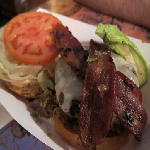

In [11]:
img = load_img(fullname, target_size=(150,150)); img

In [12]:
x = np.array(img)

In [13]:
x.shape

(150, 150, 3)

## Using Pre-trained CNN - [Keras Models](https://keras.io/api/applications/)

In [15]:
# create the model
model = MobileNet(weights='imagenet', input_shape=(224,224,3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
X = np.array([x])

In [17]:
X = preprocess_input(X)

In [18]:
X.shape

(1, 150, 150, 3)

## Transfer Learning

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

Found 2400 images belonging to 10 classes.


In [20]:
# classes of the traiing data
train_ds.class_indices

{'chicken_curry': 0,
 'chocolate_cake': 1,
 'fish_and_chips': 2,
 'hamburger': 3,
 'ice_cream': 4,
 'pad_thai': 5,
 'pizza': 6,
 'ramen': 7,
 'sushi': 8,
 'tacos': 9}

In [21]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


## Train the model

In [22]:
base_model=MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
# making no changes to the convolutional layers
base_model.trainable=False

## Creating a new top (dense layers)
inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

/tmp/ipython-input-316752229.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )


In [24]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v0{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [25]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5024 - loss: 2.7433

75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - accuracy: 0.5042 - loss: 2.7312 - val_accuracy: 0.7067 - val_loss: 1.1436
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8189 - loss: 0.6630

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8191 - loss: 0.6632 - val_accuracy: 0.7600 - val_loss: 0.9724
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9084 - loss: 0.3150 - val_accuracy: 0.7367 - val_loss: 1.2822
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9201 - loss: 0.2338 - val_accuracy: 0.7500 - val_loss: 1.1601
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9534 - loss: 0.1435 - val_accuracy: 0.7500 - val_loss: 1.1524
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9675 - loss: 0.0914

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9673 - loss: 0.0918 - val_accuracy: 0.7633 - val_loss: 1.2682
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9648 - loss: 0.0952

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9648 - loss: 0.0951 - val_accuracy: 0.7833 - val_loss: 1.2631
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9816 - loss: 0.0594 - val_accuracy: 0.7600 - val_loss: 1.3518
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9928 - loss: 0.0246 - val_accuracy: 0.7733 - val_loss: 1.4308
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9997 - loss: 0.0081 - val_accuracy: 0.7567 - val_loss: 1.4888


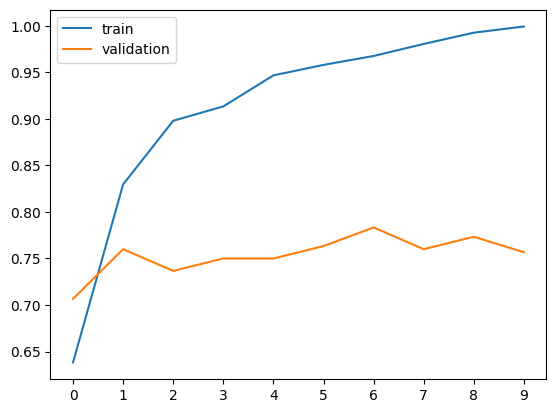

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xticks(np.arange(10))
plt.legend()

The highest validation accuracy is 0.783. Let's see if adjusting learning rate will help improve the situation.

In [28]:
!mkdir images1/

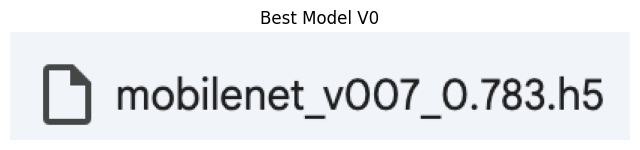

In [29]:
image_path = "./images1/best_model_v0.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V0")
plt.show()

## Adjusting Learning Rate

In [30]:
def make_model(learning_rate=0.01):
  base_model=MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [31]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v1{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [32]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
  scores[lr]=history.history

  print()
  print()

0.0001


/tmp/ipython-input-1278737392.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1364 - loss: 3.7655

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.1363 - loss: 3.7610 - val_accuracy: 0.1233 - val_loss: 2.9580
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1863 - loss: 2.7141

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.1866 - loss: 2.7121 - val_accuracy: 0.2200 - val_loss: 2.3696
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3062 - loss: 2.1570

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.3065 - loss: 2.1554 - val_accuracy: 0.3333 - val_loss: 1.9585
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4334 - loss: 1.7306

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.4335 - loss: 1.7299 - val_accuracy: 0.4233 - val_loss: 1.6798
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5030 - loss: 1.4993

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5032 - loss: 1.4986 - val_accuracy: 0.4967 - val_loss: 1.4893
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5853 - loss: 1.2982

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5853 - loss: 1.2978 - val_accuracy: 0.5233 - val_loss: 1.3440
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6106 - loss: 1.1824

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6107 - loss: 1.1819 - val_accuracy: 0.5633 - val_loss: 1.2347
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6484 - loss: 1.0635

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.6484 - loss: 1.0634 - val_accuracy: 0.5833 - val_loss: 1.1605
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6813 - loss: 0.9570

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6813 - loss: 0.9573 - val_accuracy: 0.6100 - val_loss: 1.0883
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7065 - loss: 0.9151

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7065 - loss: 0.9150 - val_accuracy: 0.6233 - val_loss: 1.0459


0.001
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3059 - loss: 2.4804

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.3081 - loss: 2.4705 - val_accuracy: 0.6633 - val_loss: 0.9763
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7496 - loss: 0.8082

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7497 - loss: 0.8077 - val_accuracy: 0.7267 - val_loss: 0.7921
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8063 - loss: 0.6290

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8064 - loss: 0.6285 - val_accuracy: 0.7733 - val_loss: 0.7091
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8641 - loss: 0.4513 - val_accuracy: 0.7567 - val_loss: 0.6837
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8866 - loss: 0.3578 - val_accuracy: 0.7567 - val_loss: 0.6832
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9170 - loss: 0.3142

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9170 - loss: 0.3141 - val_accuracy: 0.7767 - val_loss: 0.6735
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9295 - loss: 0.2636

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9295 - loss: 0.2636 - val_accuracy: 0.7867 - val_loss: 0.6154
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9551 - loss: 0.2062

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9550 - loss: 0.2064 - val_accuracy: 0.7933 - val_loss: 0.6278
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9644 - loss: 0.1803 - val_accuracy: 0.7833 - val_loss: 0.6275
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9829 - loss: 0.1439 - val_accuracy: 0.7900 - val_loss: 0.6319


0.01
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.4628 - loss: 3.2519 - val_accuracy: 0.7633 - val_loss: 1.1042
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8078 - loss: 0.8121 - val_accuracy: 0.6967 - val_loss: 1.5432
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8505 - loss: 0.5550 - val_accuracy: 0.7267 - val_loss: 1.2111
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9190 - loss: 0.2497 - val_accuracy: 0.7300 - val_loss: 1.3121
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9244 - loss: 0.2235 - val_accuracy: 0.7700 - va

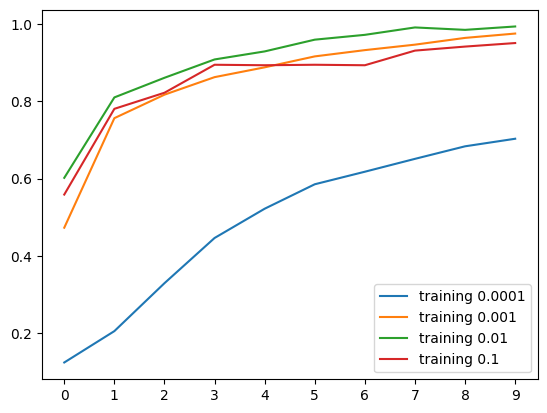

In [33]:
# training lr
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label=f'training {lr}')
plt.xticks(np.arange(10))
plt.legend()

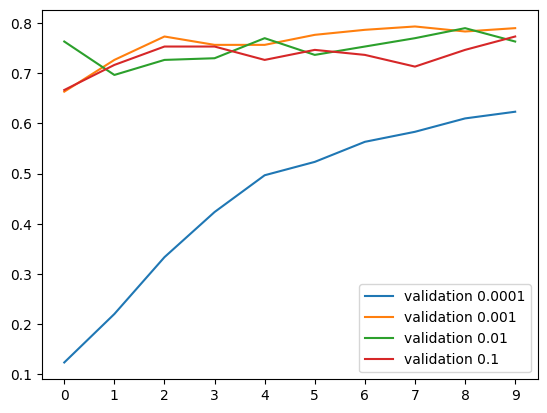

In [34]:
# validation lr
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=f'validation {lr}')
plt.xticks(np.arange(10))
plt.legend()

We are going to drop learning rate 0.0001 because the parameter yielded the lowest validation accuracy results

In [35]:
del scores [0.0001]

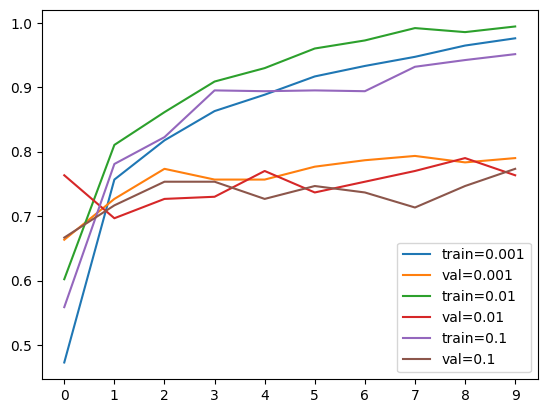

In [36]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

Since the gap between train and validation curves is smaller for lr = 0.001 than for lr = 0.01 and for 0.1, we are choosing the learning rate to be 0.001.

Further examining learning rates, both training and validation accuracy scores are the lowest for learning rate of 0.1.

In [37]:
del scores[0.01]
del scores [0.1]

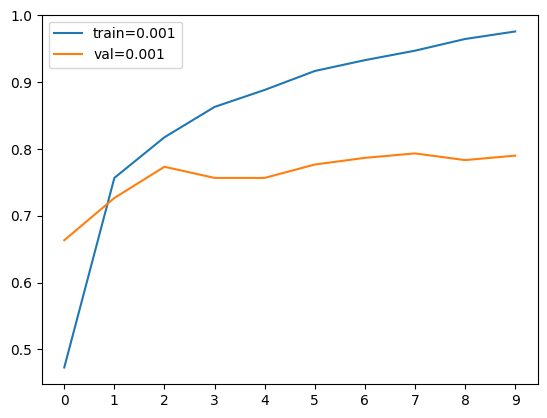

In [38]:
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

You can also notice that the best performing model so far has had the learning rate of 0.001

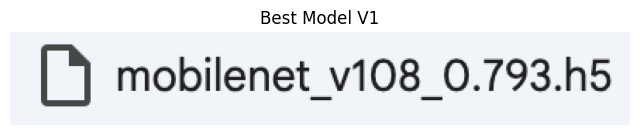

In [40]:
image_path = "./images1/best_model_v1.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1")
plt.show()

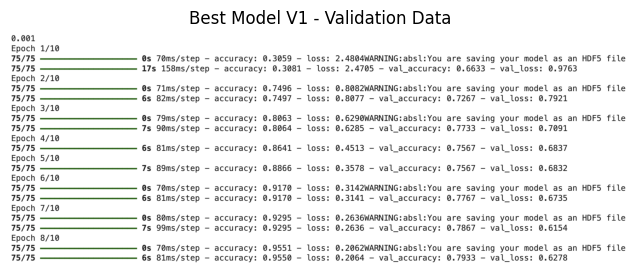

In [41]:
image_path = "./images1/best_model_v1_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1 - Validation Data")
plt.show()

You can see that the 8th epoch is the one that was saved as the best performer.

## Checkpointing - saving the best performing models

At this point, we are simply going to run the best performing model again.

In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v2{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [43]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint])


/tmp/ipython-input-1278737392.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3251 - loss: 2.2371

75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.3270 - loss: 2.2298 - val_accuracy: 0.6533 - val_loss: 0.9999
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7298 - loss: 0.8461

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7300 - loss: 0.8454 - val_accuracy: 0.7133 - val_loss: 0.8292
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8120 - loss: 0.5703

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8120 - loss: 0.5705 - val_accuracy: 0.7500 - val_loss: 0.7360
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8604 - loss: 0.4494

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8603 - loss: 0.4496 - val_accuracy: 0.7533 - val_loss: 0.7196
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8792 - loss: 0.3846 - val_accuracy: 0.7533 - val_loss: 0.6822
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9233 - loss: 0.2932

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9233 - loss: 0.2934 - val_accuracy: 0.7633 - val_loss: 0.6794
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9241 - loss: 0.2896

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9242 - loss: 0.2892 - val_accuracy: 0.7900 - val_loss: 0.6312
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9599 - loss: 0.2024 - val_accuracy: 0.7700 - val_loss: 0.6629
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9682 - loss: 0.1765 - val_accuracy: 0.7733 - val_loss: 0.6730
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9748 - loss: 0.1509 - val_accuracy: 0.7833 - val_loss: 0.6459


The best model for the second version had the validation accuracy of 0.790.

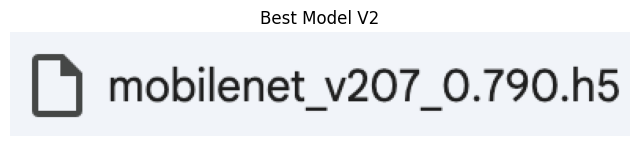

In [45]:
image_path = "./images1/best_model_v2.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V2")
plt.show()

## Adding more layers

Let's test to see if adding more dense layers will improve the model performance.

In [46]:
def make_model_more_layers(learning_rate=0.001, size_inner=100):
  base_model=MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(10)(inner)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v3{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [48]:
learning_rate = 0.001

scores_inner_layer = {}

for size in [10, 100, 1000]:
  print(size)
  model = make_model_more_layers(learning_rate=learning_rate, size_inner=size)
  history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint])
  scores_inner_layer[size]=history.history

  print()
  print()

10


/tmp/ipython-input-306241554.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1427 - loss: 2.6221

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.1435 - loss: 2.6169 - val_accuracy: 0.3733 - val_loss: 1.8586
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3850 - loss: 1.6765

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3856 - loss: 1.6752 - val_accuracy: 0.5100 - val_loss: 1.3972
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5628 - loss: 1.2727

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5633 - loss: 1.2717 - val_accuracy: 0.6400 - val_loss: 1.1611
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7181 - loss: 0.9345

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7179 - loss: 0.9346 - val_accuracy: 0.6767 - val_loss: 1.0667
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.7495 - loss: 0.8067 - val_accuracy: 0.6767 - val_loss: 1.0371
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7759 - loss: 0.7396

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7761 - loss: 0.7391 - val_accuracy: 0.7033 - val_loss: 0.9550
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8171 - loss: 0.6129

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8171 - loss: 0.6130 - val_accuracy: 0.7067 - val_loss: 0.9584
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8394 - loss: 0.5510 - val_accuracy: 0.6867 - val_loss: 0.9712
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8621 - loss: 0.4660

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8619 - loss: 0.4666 - val_accuracy: 0.7133 - val_loss: 0.9364
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8737 - loss: 0.4329 - val_accuracy: 0.7033 - val_loss: 0.9357
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8939 - loss: 0.4136 - val_accuracy: 0.7100 - val_loss: 0.9649
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.8896 - loss: 0.4063 - val_accuracy: 0.7067 - val_loss: 0.9492
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9159 - loss: 0.3502 - val_accuracy: 0.6933 - val_loss: 0.9747
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9313 - loss: 0.3161

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9311 - loss: 0.3163 - val_accuracy: 0.7167 - val_loss: 0.9898
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9361 - loss: 0.2867 - val_accuracy: 0.7067 - val_loss: 0.9834
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9447 - loss: 0.2720 - val_accuracy: 0.6800 - val_loss: 0.9919
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9329 - loss: 0.2574 - val_accuracy: 0.6800 - val_loss: 0.9884
Epoch 18/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9404 - loss: 0.2451 - val_accuracy: 0.7100 - val_loss: 1.0075
Epoch 19/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9609 - loss: 0.2145 - val_accuracy: 0.6967 - val_loss: 0.9984
Epoch 20/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9583 - loss: 0.2055 - val_accuracy: 0.7167 - val_loss: 1.0261


100
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.4556 - loss: 1.7801 - val_accuracy: 0.6900 

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8237 - loss: 0.5446 - val_accuracy: 0.7333 - val_loss: 0.7246
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8918 - loss: 0.3548

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8918 - loss: 0.3549 - val_accuracy: 0.7433 - val_loss: 0.6758
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9499 - loss: 0.2120

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9498 - loss: 0.2122 - val_accuracy: 0.7733 - val_loss: 0.6630
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9785 - loss: 0.1335

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9784 - loss: 0.1335 - val_accuracy: 0.7800 - val_loss: 0.7277
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9915 - loss: 0.0830 - val_accuracy: 0.7800 - val_loss: 0.6770
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9987 - loss: 0.0457 - val_accuracy: 0.7633 - val_loss: 0.6846
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.7733 - val_loss: 0.7019
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.7767 - val_loss: 0.7188
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0165

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.7867 - val_loss: 0.7239
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.7733 - val_loss: 0.7418
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.7800 - val_loss: 0.7506
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.7867 - val_loss: 0.7582
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.7767 - val_loss: 0.7649
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7767 - val_loss: 0.7717
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.7767 - val_loss: 0.7766
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.7867 - val_l

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9934 - loss: 0.0558 - val_accuracy: 0.8067 - val_loss: 0.7008
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0168

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.8233 - val_loss: 0.6848
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8100 - val_loss: 0.6929
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.8167 - val_loss: 0.7036
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.8233 - val_loss: 0.7274
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.8133 - val_loss: 0.7472
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.8133 - val_loss: 0.7329
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.8100 - val_loss: 0.7484
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8133 - val_loss

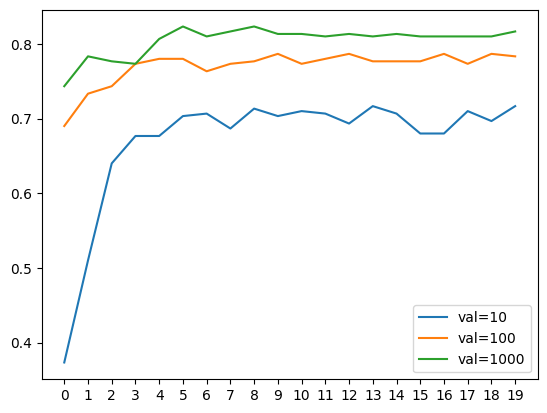

In [49]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  #plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.legend()

The 10 option for the dense layers was consistently underperforming, so we are going to remove it.

In [50]:
del scores_inner_layer[10]

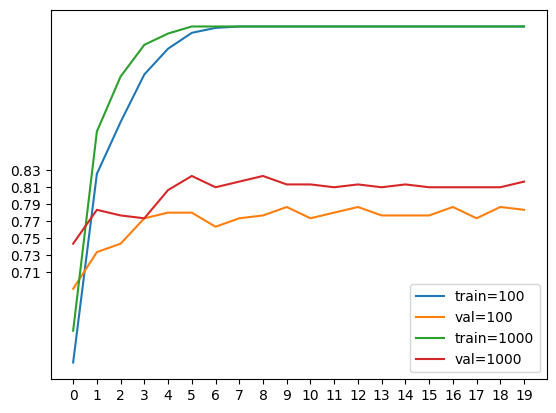

In [52]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.yticks([0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83])
plt.legend()

I'll choose a 1000 for the inner layer size since it is giving higher validation accuracy majority of the time

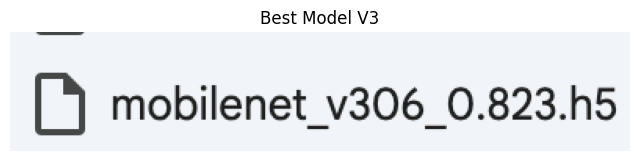

In [53]:
image_path = "./images1/best_model_v3.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3")
plt.show()

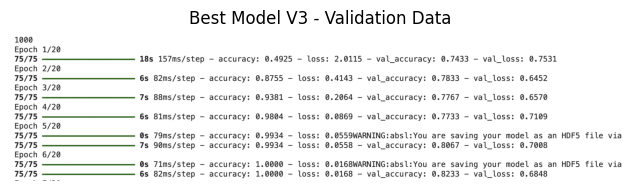

In [54]:
image_path = "./images1/best_model_v3_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3 - Validation Data")
plt.show()

You can see that the 6th epoch is the one that was saved as the best performer. Let's see if regularization and dropout will help with preventing overfitting the model.

## Regularization and Dropout

In [55]:
def make_model_more_layers_and_drop(learning_rate=0.001, size_inner=1000, droprate=0.2):
  base_model=MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [56]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v4{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [57]:
learning_rate = 0.001
size = 1000
scores_droprate = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
  print(droprate)
  model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
  history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])
  scores_droprate[droprate]=history.history

  print()
  print()

0.0


/tmp/ipython-input-3556173858.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5379 - loss: 1.9419

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.5395 - loss: 1.9327 - val_accuracy: 0.7533 - val_loss: 0.7700
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8663 - loss: 0.4265

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8663 - loss: 0.4262 - val_accuracy: 0.7867 - val_loss: 0.7019
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9506 - loss: 0.1783 - val_accuracy: 0.7767 - val_loss: 0.7601
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9816 - loss: 0.0983

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9817 - loss: 0.0981 - val_accuracy: 0.8033 - val_loss: 0.7291
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9986 - loss: 0.0307 - val_accuracy: 0.8033 - val_loss: 0.6905
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.8033 - val_loss: 0.6797
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.7967 - val_loss: 0.7020
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0043

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8133 - val_loss: 0.7124
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8133 - val_loss: 0.7344
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8033 - val_loss: 0.7324
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8133 - val_loss: 0.7488
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0020

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8167 - val_loss: 0.7536
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8067 - val_loss: 0.7489
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8133 - val_loss: 0.7582
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8167 - val_loss: 0.7698
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8067 - val_loss: 0.7787
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8100 - val_loss: 0.7799
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8067 - val_loss: 0.7841
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 8.8695e-04 - val_accuracy: 0.8100 - v

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8200 - val_loss: 0.8023
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8133 - val_loss: 0.7794
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8067 - val_loss: 0.8056
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8067 - val_loss: 0.8311
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0014

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8233 - val_loss: 0.8439
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8200 - val_loss: 0.8172
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8100 - val_loss: 0.8007
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 8.3585e-04 - val_accuracy: 0.8100 - val_loss: 0.8188
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.6414e-04

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 9.6436e-04 - val_accuracy: 0.8267 - val_loss: 0.7978
Epoch 24/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 1.0000 - loss: 9.6956e-04 - val_accuracy: 0.8233 - val_loss: 0.7976
Epoch 25/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 8.7315e-04 - val_accuracy: 0.8167 - val_loss: 0.8154
Epoch 26/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 1.0000 - loss: 6.7961e-04 - val_accuracy: 0.8167 - val_loss: 0.8050
Epoch 27/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 1.0000 - loss: 6.9683e-04 - val_accuracy: 0.8200 - val_loss: 0.8410
Epoch 28/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 5.7232e-04 - val_accuracy: 0.8200 - val_loss: 0.8298
Epoch 29/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 1.0000 - loss: 5.5024e-04 - val_accuracy: 0.8100 - val_loss: 0.8099
Epoch 30/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 7.1172e-0

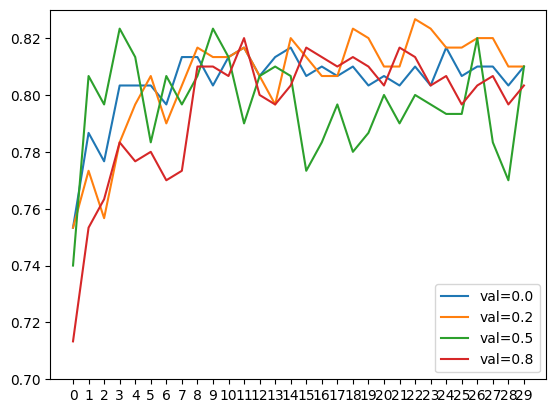

In [58]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for droprate, hist in scores_droprate.items():
  #plt.plot(hist['accuracy'], label='train=%s' % droprate)
  plt.plot(hist['val_accuracy'], label='val=%s' % droprate)
plt.xticks(np.arange(30))
plt.ylim(0.70, 0.83)
plt.legend()

Towards the end, the droprates diverge. It kind of looks like 0.0 and 0.2 droprate have the best validation accuracy results.

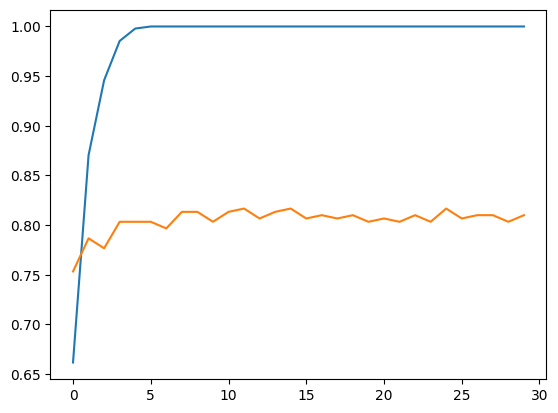

In [59]:
hist = scores_droprate[0.0]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

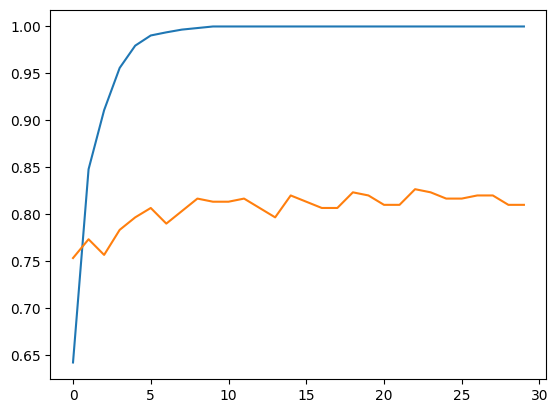

In [60]:
hist = scores_droprate[0.2]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

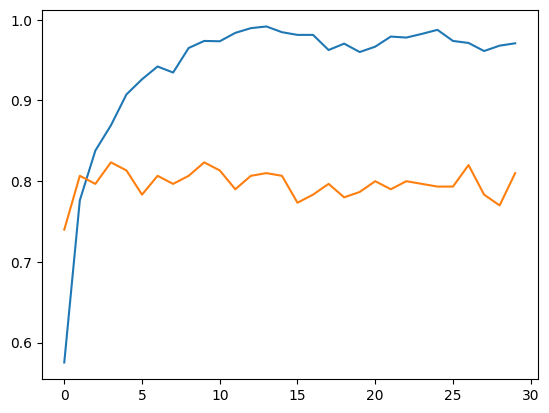

In [61]:
hist = scores_droprate[0.5]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

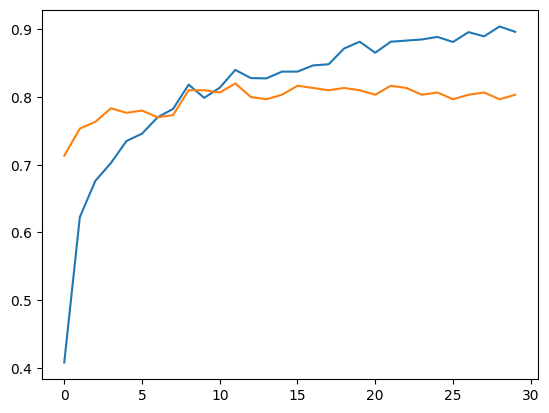

In [62]:
hist = scores_droprate[0.8]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

Conclusion: for 0.8, the validation scores oscillate around 0.78. For 0.5, the validation scores oscillate around 0.79, for 0.2, the validation accuracy scores oscillate around 0.80, and the validation accuracy score for 0.0 oscillate around 0.80. Looks like 0.0 and 0.2 should be inspected further

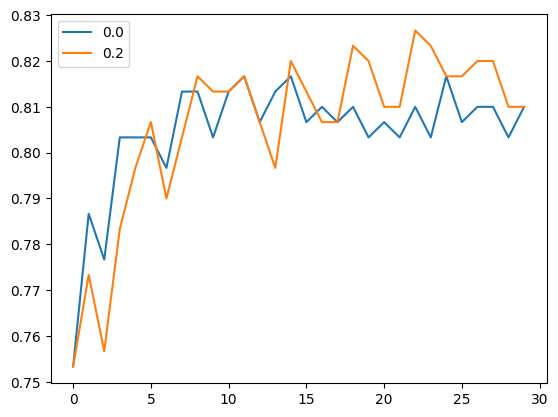

In [63]:
hist = scores_droprate[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores_droprate[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

Even though both 0.0 and 0.2 drop rates have a similar pattern, towards the end it seems that 0.2 consistently yields better results. Let's use 0.2 to prevent overfitting and yield higher validation accuracy results.

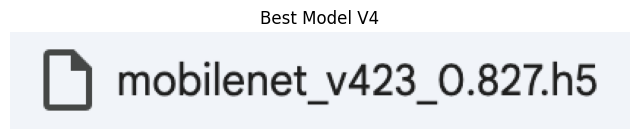

In [64]:
image_path = "./images1/best_model_v4.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4")
plt.show()

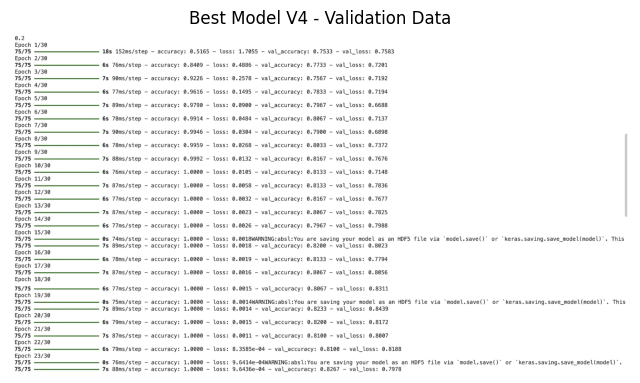

In [65]:
image_path = "./images1/best_model_v4_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4 - Validation Data")
plt.show()

You can see that the droprate of 0.2 yielded the highest validation accuracy of 0.8 on the 23rd epoch.

Let's see if data augmentation can help, too.

## Data Augmentation

In [66]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    vertical_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [67]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v5{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

Let's first re-train the best model with 50 epochs.

In [68]:
learning_rate = 0.001
size = 1000
droprate = 0.2

model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

/tmp/ipython-input-3556173858.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4519 - loss: 2.4024

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - accuracy: 0.4539 - loss: 2.3909 - val_accuracy: 0.7700 - val_loss: 0.7359
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.7844 - loss: 0.6376 - val_accuracy: 0.7467 - val_loss: 0.7182
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8205 - loss: 0.5579 - val_accuracy: 0.7700 - val_loss: 0.7381
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8777 - loss: 0.3770 - val_accuracy: 0.7700 - val_loss: 0.7013
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8943 - loss: 0.3140

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8943 - loss: 0.3140 - val_accuracy: 0.7833 - val_loss: 0.6721
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9187 - loss: 0.2794 - val_accuracy: 0.7833 - val_loss: 0.6677
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9398 - loss: 0.1853 - val_accuracy: 0.7567 - val_loss: 0.8200
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9419 - loss: 0.1634

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9419 - loss: 0.1636 - val_accuracy: 0.7867 - val_loss: 0.7025
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9538 - loss: 0.1398 - val_accuracy: 0.7500 - val_loss: 0.7690
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9717 - loss: 0.0857 - val_accuracy: 0.7833 - val_loss: 0.7745
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9822 - loss: 0.0653

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9822 - loss: 0.0653 - val_accuracy: 0.8100 - val_loss: 0.7515
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9858 - loss: 0.0600 - val_accuracy: 0.7933 - val_loss: 0.7674
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9905 - loss: 0.0428 - val_accuracy: 0.7867 - val_loss: 0.7584
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9900 - loss: 0.0391 - val_accuracy: 0.7767 - val_loss: 0.7448
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9910 - loss: 0.0355 - val_accuracy: 0.7933 - val_loss: 0.9072
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9894 - loss: 0.0351 - val_accuracy: 0.7933 - val_loss: 0.8942
Epoch 17/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9935 - loss: 0.0274 - val_accuracy: 0.7933 - val_loss: 0.8854
Epoch 18/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9904 - loss: 0.0337

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9904 - loss: 0.0337 - val_accuracy: 0.8167 - val_loss: 0.7955
Epoch 19/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9901 - loss: 0.0360 - val_accuracy: 0.7967 - val_loss: 0.9075
Epoch 20/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9886 - loss: 0.0395 - val_accuracy: 0.8033 - val_loss: 0.8896
Epoch 21/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9835 - loss: 0.0509 - val_accuracy: 0.7900 - val_loss: 0.8422
Epoch 22/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9881 - loss: 0.0409 - val_accuracy: 0.7567 - val_loss: 1.0858
Epoch 23/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9845 - loss: 0.0423 - val_accuracy: 0.7833 - val_loss: 0.9315
Epoch 24/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9763 - loss: 0.0775 - val_accuracy: 0.7733 - val_loss: 0.9232
Epoch 25/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9862 - loss: 0.0400 - val_accuracy: 0.7800 - val_l

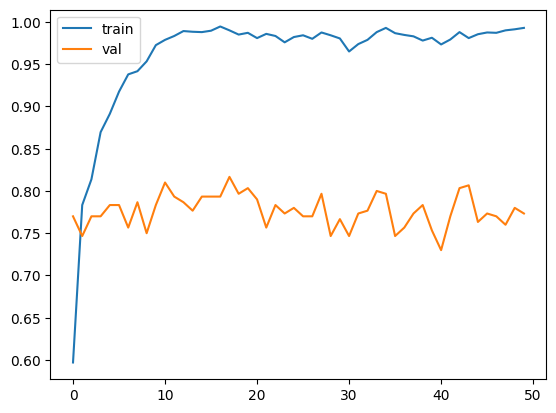

In [69]:
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.legend()

Conclusion: applying augmentation to smaller models makes the performance worse, so we are not going to use it.

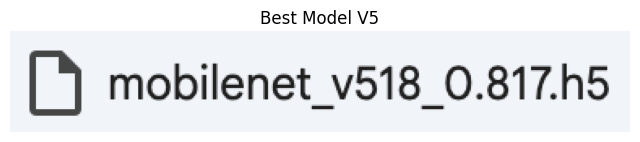

In [70]:
image_path = "./images1/best_model_v5.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V5")
plt.show()

## Training a larger model

In [71]:
def make_model_more_layers_and_drop_large(input_size=150,learning_rate=0.001, size_inner=100, droprate=0.2):
  base_model=MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size,input_size,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(input_size,input_size,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [72]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(299,299),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [73]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_v6{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [74]:
learning_rate = 0.0005
size = 1000
droprate = 0.2
input_size=299

model = make_model_more_layers_and_drop_large(input_size=299, learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

/tmp/ipython-input-1212481754.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.5211 - loss: 1.4264

75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 879ms/step - accuracy: 0.5229 - loss: 1.4210 - val_accuracy: 0.7733 - val_loss: 0.6774
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.8334 - loss: 0.5111

75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 726ms/step - accuracy: 0.8333 - loss: 0.5111 - val_accuracy: 0.8233 - val_loss: 0.5348
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 712ms/step - accuracy: 0.8909 - loss: 0.3586 - val_accuracy: 0.8200 - val_loss: 0.5597
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9021 - loss: 0.3022

75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 714ms/step - accuracy: 0.9020 - loss: 0.3024 - val_accuracy: 0.8300 - val_loss: 0.5663
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 714ms/step - accuracy: 0.9323 - loss: 0.2315 - val_accuracy: 0.8167 - val_loss: 0.6223
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9169 - loss: 0.2371

75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 718ms/step - accuracy: 0.9170 - loss: 0.2368 - val_accuracy: 0.8333 - val_loss: 0.5018
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 730ms/step - accuracy: 0.9650 - loss: 0.1338 - val_accuracy: 0.8267 - val_loss: 0.5639
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 710ms/step - accuracy: 0.9539 - loss: 0.1553 - val_accuracy: 0.8300 - val_loss: 0.5180
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9787 - loss: 0.0839

75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 718ms/step - accuracy: 0.9786 - loss: 0.0841 - val_accuracy: 0.8433 - val_loss: 0.5398
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 726ms/step - accuracy: 0.9804 - loss: 0.0825 - val_accuracy: 0.8367 - val_loss: 0.5644
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 718ms/step - accuracy: 0.9806 - loss: 0.0800 - val_accuracy: 0.8367 - val_loss: 0.5992
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 721ms/step - accuracy: 0.9819 - loss: 0.0693 - val_accuracy: 0.8067 - val_loss: 0.6418
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 723ms/step - accuracy: 0.9765 - loss: 0.0791 - val_accuracy: 0.8333 - val_loss: 0.5396
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 712ms/step - accuracy: 0.9903 - loss: 0.0490 - val_accuracy: 0.8433 - val_loss: 0.5795
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 711ms/step - accuracy: 0.9879 - loss: 0.0472 - val_accuracy: 0.8333 - val_loss: 0.5863
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 717ms/step - accuracy: 0.9891 - loss: 0.0436 - val_accuracy

75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 737ms/step - accuracy: 0.9965 - loss: 0.0245 - val_accuracy: 0.8533 - val_loss: 0.5744
Epoch 20/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 714ms/step - accuracy: 0.9981 - loss: 0.0218 - val_accuracy: 0.8333 - val_loss: 0.6060
Epoch 21/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 713ms/step - accuracy: 0.9948 - loss: 0.0224 - val_accuracy: 0.8433 - val_loss: 0.6155
Epoch 22/50
48/75 ━━━━━━━━━━━━━━━━━━━━ 19s 706ms/step - accuracy: 0.9953 - loss: 0.0249

KeyboardInterrupt: 

I've interrupted the code for training to not run out of the TPU resources I have been provided by Google Colab.

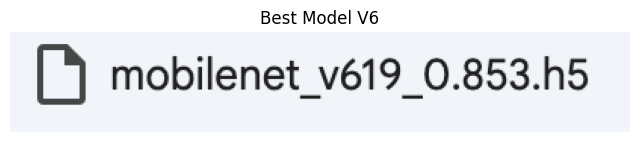

In [76]:
image_path = "./images1/best_model_v6.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

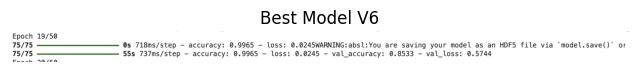

In [77]:
image_path = "./images1/best_model_v6_val_data.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

We can see that on the 19th epoch for the larger model the highest accuracy has been yielded of 0.853. I did not run all 50 epochs of training since I did not want to run out of TPU.

## Using the model

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import load_img

In [79]:
model = keras.models.load_model('mobilenet_v619_0.853.h5')

In [80]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    './food-101/test',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


In [81]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.8487 - loss: 0.5034


[0.4903438687324524, 0.8700000047683716]

The test accuracy of the data is 0.892, which is not far off from 0.887 of the validation data. This means that the model did not overfit, which is a great thing!

## Applying the model to the image

In [82]:
path = './food-101/test/hamburger/170292.jpg'

In [83]:
img = load_img(path, target_size=(299,299))

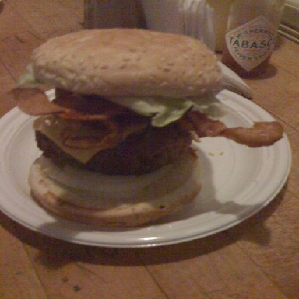

In [84]:
img

In [85]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [86]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

In [87]:
prediction = dict(zip(classes,pred[0]))

In [88]:
prediction

{'chicken_curry': np.float32(0.30691004),
 'chocolate_cake': np.float32(3.8400497),
 'fish_and_chips': np.float32(2.630807),
 'hamburger': np.float32(10.475048),
 'ice_cream': np.float32(5.8682804),
 'pad_thai': np.float32(-9.202665),
 'pizza': np.float32(-5.6986294),
 'ramen': np.float32(-7.0913453),
 'sushi': np.float32(-3.1830568),
 'tacos': np.float32(-5.723419)}

So, it looks like the model output hamburger as our prediction, which is right :)

## Export the model to ONNX

In [89]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 121.4 MB/s eta 0:00:00


In [90]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: onnx
    Found existing installation: onnx 1.20.0
    Uninstalling onnx-1.20.0:
      Successfully uninstalled onnx-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires 

In [106]:
# Export to ONNX
onnx_path = "food_classifier_mobilenet_v6.onnx"

import tensorflow as tf
from tensorflow import keras
import tf2onnx
import tf2onnx.convert
import onnx

In [107]:
# 1. Load your Keras model (e.g., from an H5 file)
keras_model = keras.models.load_model('mobilenet_v619_0.853.h5')


In [108]:
# 2. Define input signature - corrected version
input_signature = [tf.TensorSpec(keras_model.input[0].shape, keras_model.input[0].dtype, name="input")]

# 3. Convert to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(keras_model,
                                         input_signature=input_signature,  # Use the variable, not the shape
                                  )

# 4. Save the ONNX model
onnx.save(onnx_model, onnx_path)

print(f"Model converted and saved to {onnx_path}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x786e76760cc0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model converted and saved to food_classifier_mobilenet_v6.onnx


## Testing the ONNX model

In [109]:
!pip install onnxruntime

In [110]:
import onnxruntime as ort
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

In [111]:
# 1. Load the ONNX model
onnx_session = ort.InferenceSession(onnx_path)

# 2. Check model info
print("ONNX model loaded successfully!")
print(f"Input name: {onnx_session.get_inputs()[0].name}")
print(f"Input shape: {onnx_session.get_inputs()[0].shape}")
print(f"Output name: {onnx_session.get_outputs()[0].name}")
print(f"Output shape: {onnx_session.get_outputs()[0].shape}")

ONNX model loaded successfully!
Input name: input
Input shape: ['unk__793', 299, 299, 3]
Output name: dense_23
Output shape: ['unk__794', 10]


In [112]:
# 3. Prepare test data (same preprocessing as your training)
def prepare_image(image_path):
    # Load and resize image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))

    # Preprocess (same as training)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)

    return img.astype(np.float32)

In [113]:
# 4. Test with an image
test_image_path = "./food-101/test/hamburger/170292.jpg"  # Replace with actual path
input_data = prepare_image(test_image_path)

# 5. Run inference
input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

onnx_outputs = onnx_session.run([output_name], {input_name: input_data})
onnx_prediction = onnx_outputs[0]

print(f"ONNX prediction shape: {onnx_prediction.shape}")
print(f"ONNX prediction: {onnx_prediction}")



ONNX prediction shape: (1, 10)
ONNX prediction: [[-0.13528213  3.9605265   3.6403313   9.802688    5.659692   -8.568069
  -5.8112974  -7.906036   -3.1658692  -5.1623936 ]]


In [114]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

# Also, you need to flatten the ONNX prediction array
prediction_onnx = dict(zip(classes, onnx_prediction[0]))  # Note the [0] to get the first (and only) sample

In [115]:
prediction_onnx

{'chicken_curry': np.float32(-0.13528213),
 'chocolate_cake': np.float32(3.9605265),
 'fish_and_chips': np.float32(3.6403313),
 'hamburger': np.float32(9.802688),
 'ice_cream': np.float32(5.659692),
 'pad_thai': np.float32(-8.568069),
 'pizza': np.float32(-5.8112974),
 'ramen': np.float32(-7.906036),
 'sushi': np.float32(-3.1658692),
 'tacos': np.float32(-5.1623936)}

In [116]:
# 6. Compare with original Keras model (optional)
keras_prediction = keras_model.predict(input_data)
print(f"Keras prediction: {keras_prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Keras prediction: [[-0.13526356  3.9605317   3.6403346   9.802681    5.6596904  -8.568058
  -5.811286   -7.9060373  -3.1658728  -5.16242   ]]


In [117]:
# Flatten the ONNX prediction array
prediction_keras = dict(zip(classes, keras_prediction[0]))

In [118]:
prediction_keras

{'chicken_curry': np.float32(-0.13526356),
 'chocolate_cake': np.float32(3.9605317),
 'fish_and_chips': np.float32(3.6403346),
 'hamburger': np.float32(9.802681),
 'ice_cream': np.float32(5.6596904),
 'pad_thai': np.float32(-8.568058),
 'pizza': np.float32(-5.811286),
 'ramen': np.float32(-7.9060373),
 'sushi': np.float32(-3.1658728),
 'tacos': np.float32(-5.16242)}

In [119]:
# check if predicitons are close
max_value_keras = max(prediction_keras.values())
max_value_onnx = max(prediction_onnx.values())
print(f"Max value keras: {max_value_keras}")
print(f"Max value onnx: {max_value_onnx}")

Max value keras: 9.802680969238281
Max value onnx: 9.802687644958496


In [120]:
# Check if predictions are close
diff = np.abs(max_value_onnx - max_value_keras)
print(f"Max difference: {np.max(diff)}")
print(f"Are predictions close? {np.allclose(max_value_onnx, max_value_keras, atol=1e-5)}")

Max difference: 6.67572021484375e-06
Are predictions close? True


Looks like the scores for the 2 models are not significantly different. both of the models output hamburger as a final prediction, which is correct and cool. We are going to use ONNX model for the training and predicting the food.